# Notebook: inference with GLPN (Global-Local Path Networks) for monocular depth estimation

In this notebook, we are going to perform inference with [GLPN](https://arxiv.org/abs/2201.07436), which uses [SegFormer](https://huggingface.co/docs/transformers/master/en/model_doc/segformer)'s MiT-b4 (Mix Transformer) as encoder and a lightweight decoder for **monocular depth estimation** from a single image. The architecture (taken from the original paper) is shown below.

![architecture](https://huggingface.co/datasets/huggingface/documentation-images/resolve/main/glpn_architecture.jpg)


## Set-up environment

First, we install HuggingFace Transformers and OpenCV (the latter is not required - it will only be useful for some fancy visualization).

In [1]:
!pip install -q git+https://github.com/huggingface/transformers.git

## Define model and feature extractor

Next, we instantiate a feature extractor (which can be used to prepare images for the model), and the model itself with weights hosted on the hub.

In [2]:
from transformers import GLPNFeatureExtractor, GLPNForDepthEstimation

feature_extractor = GLPNFeatureExtractor.from_pretrained("vinvino02/glpn-kitti")
model = GLPNForDepthEstimation.from_pretrained("vinvino02/glpn-kitti")

Downloading: 100%|██████████| 920/920 [00:00<00:00, 448kB/s]
Downloading: 100%|██████████| 234M/234M [00:22<00:00, 11.1MB/s]   


## Prepare image

Let's prepare an image for the model!

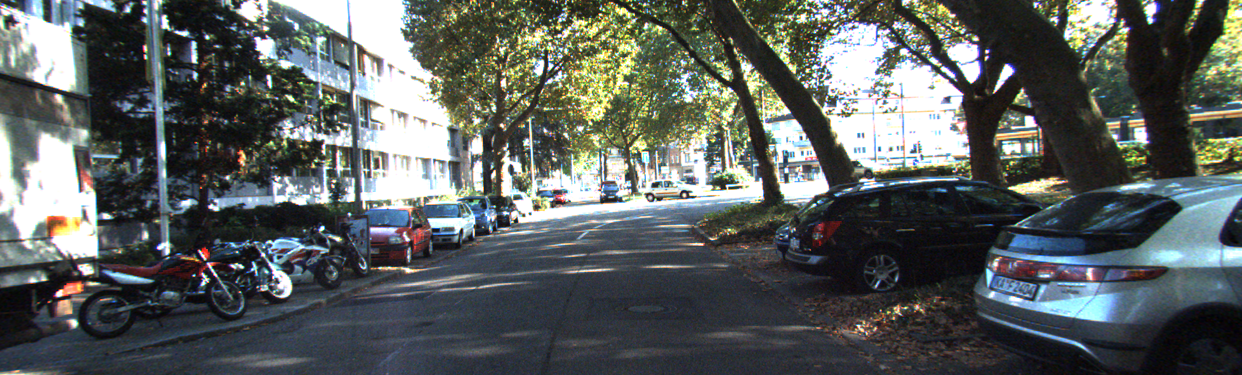

In [3]:
from PIL import Image
import requests

image = Image.open('/home/joonsu0109/Joon/Image_to_Point/set/000002.png')
image

In [4]:
pixel_values = feature_extractor(image, return_tensors="pt").pixel_values
print(pixel_values.shape)

torch.Size([1, 3, 352, 1216])


## Forward pass

In [5]:
import torch

with torch.no_grad():
  outputs = model(pixel_values)
  predicted_depth = outputs.predicted_depth

In [6]:
predicted_depth.shape

torch.Size([1, 352, 1216])

## Visualize

We can visualize the predicted depth in multiple ways. Here's the visualization using Matplotlib:

In [7]:
# interpolate to original size
prediction = torch.nn.functional.interpolate(
                    predicted_depth.unsqueeze(1),
                    size=pixel_values.shape[-2:],
                    mode="bicubic",
                    align_corners=False,
             )
prediction = prediction.squeeze().cpu().numpy()

In [8]:
import numpy as np

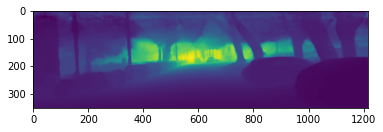

In [78]:
#normalize
depth_map = cv2.normalize(prediction, None, 0, 1, norm_type=cv2.NORM_MINMAX, dtype=cv2.CV_32F)
formatted = (depth_map * 255).astype(np.uint8)
plt.imshow(formatted)
cv2.imwrite('depth_nomalized.jpg', formatted)

In [74]:
GLPN = (prediction * 255 / np.max(prediction)).astype(np.uint8)
plt.imshow(GLPN)
cv2.imwrite('depth_code.jpg', GLPN)

In [11]:
#GLPN original code
formatted_origin = (prediction * 255 / np.max(prediction)).astype("uint8")
depth_origin = Image.fromarray(formatted_origin)
depth_origin.save('depth_origin.jpg')

---


Alternatively, we can use Numpy and OpenCV:

In [ ]:
import numpy as np
import cv2

def write_depth(depth, bits):
  depth_min = depth.min()
  depth_max = depth.max()

  max_val = (2 ** (8 * bits)) - 1

  if depth_max - depth_min > np.finfo("float").eps:
      out = max_val * (depth - depth_min) / (depth_max - depth_min)
  else:
      out = np.zeros(depth.shape, dtype=depth.dtype)

  cv2.imwrite("result.png", out.astype("uint16"), [cv2.IMWRITE_PNG_COMPRESSION, 0])
  
  return

In [ ]:
write_depth(prediction, bits=2)

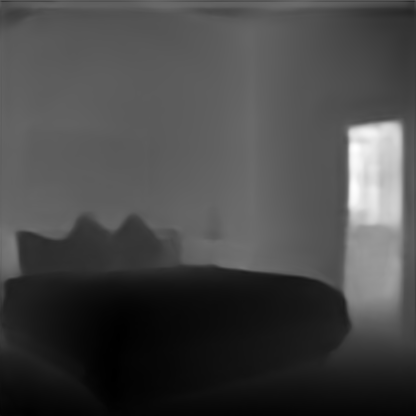

In [ ]:
Image.open('result.png')

We can also leverage OpenCV's COLORMAP_RAINBOW functionality for visualization:

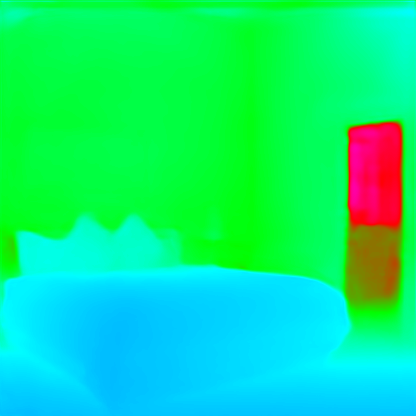

In [ ]:
pred_d_numpy = (prediction / prediction.max()) * 255
pred_d_numpy = pred_d_numpy.astype(np.uint8)
pred_d_color = cv2.applyColorMap(pred_d_numpy, cv2.COLORMAP_RAINBOW)
Image.fromarray(pred_d_color)

In [ ]:
pred_d_numpy = (prediction / prediction.max()) * 255
pred_d_numpy = pred_d_numpy.astype(np.uint8)
pred_d_color = cv2.applyColorMap(pred_d_numpy, cv2.COLORMAP_RAINBOW)
Image.fromarray(pred_d_color)